# Colorization Dataset Analysis (EDA)

## Imports and Setup

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import random
import cv2

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
random.seed(42)


TRAIN_DIR = "./data_subset/train"
VAL_DIR = "./data_subset/val"
TEST_DIR = "./data_subset/test"
SAMPLE_SIZE = 1000 
HPARAMS_PATH = "hyperparameters.json"

c:\Users\apoor\mlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Overview

In [11]:
# Load hyperparameters
try:
    with open(HPARAMS_PATH, 'r') as f:
        hparams = json.load(f)
    print("=== Dataset Configuration ===")
    print(f"Train size: {hparams.get('train_size', 'Unknown')}")
    print(f"Val size: {hparams.get('val_size', 'Unknown')}")
    print(f"Test size: {hparams.get('test_size', 'Unknown')}")
    print(f"Resolution: {hparams.get('resolution', 'Unknown')}")
except:
    print("Could not load hyperparameters")

# Count actual files
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

train_count = count_images(TRAIN_DIR)
val_count = count_images(VAL_DIR)
test_count = count_images(TEST_DIR)

print("\n=== Actual File Counts ===")
print(f"Train: {train_count} images")
print(f"Val: {val_count} images")
print(f"Test: {test_count} images")
print(f"Total: {train_count + val_count + test_count} images")

# Check if directories exist
for name, path in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    status = "Found:" if os.path.exists(path) else "NOT Found!"
    print(f"{status} {name}: {path}")

=== Dataset Configuration ===
Train size: 25000
Val size: 2500
Test size: 5000
Resolution: 256

=== Actual File Counts ===
Train: 25000 images
Val: 2500 images
Test: 5000 images
Total: 32500 images
Found: Train: ./data_subset/train
Found: Val: ./data_subset/val
Found: Test: ./data_subset/test


## Color Distribution Analysis

In [ ]:
def rgb_to_lab_numpy(rgb_img):
    """Convert RGB image to LAB using OpenCV"""
    
    bgr_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
    
    lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
    return lab_img

def analyze_image_colors(img_path):
    """Analyze color content of a single image"""
    try:
        
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        
        lab_img = rgb_to_lab_numpy(img_array)
        
        L = lab_img[:, :, 0] / 100.0  
        A = lab_img[:, :, 1] / 110.0  
        B = lab_img[:, :, 2] / 110.0  
        
        saturation = np.sqrt(A**2 + B**2)
        
        red_mask = (A > 0.3) & (saturation > 0.4)  
        
        stats = {
            'filename': os.path.basename(img_path),
            'total_pixels': img_array.shape[0] * img_array.shape[1],
            'red_pixels': np.sum(red_mask),
            'red_percentage': np.sum(red_mask) / (img_array.shape[0] * img_array.shape[1]) * 100,
            'avg_saturation': np.mean(saturation),
            'max_saturation': np.max(saturation),
            'avg_a_channel': np.mean(A),
            'avg_b_channel': np.mean(B),
            'high_sat_pixels': np.sum(saturation > 0.5),
            'high_sat_percentage': np.sum(saturation > 0.5) / (img_array.shape[0] * img_array.shape[1]) * 100
        }
        
        return stats, A.flatten(), B.flatten(), saturation.flatten()
        
    except Exception as e:
        print(f"Error analyzing {img_path}: {e}")
        return None, None, None, None

def sample_images_from_dir(directory, sample_size):
    """Sample random images from directory"""
    if not os.path.exists(directory):
        return []
    
    all_images = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_size = min(sample_size, len(all_images))
    sampled = random.sample(all_images, sample_size)
    
    return [os.path.join(directory, f) for f in sampled]

In [4]:
# Sample images from training set
print(f"Sampling {SAMPLE_SIZE} images from training set for analysis...")
train_sample_paths = sample_images_from_dir(TRAIN_DIR, SAMPLE_SIZE)
print(f"Analyzing {len(train_sample_paths)} training images...")

# Analyze sampled images
train_stats = []
all_a_values = []
all_b_values = []
all_saturations = []

for img_path in tqdm(train_sample_paths, desc="Analyzing images"):
    stats, a_vals, b_vals, sat_vals = analyze_image_colors(img_path)
    
    if stats is not None:
        train_stats.append(stats)
        if a_vals is not None:
            # Subsample for memory efficiency
            subsample_idx = np.random.choice(len(a_vals), min(1000, len(a_vals)), replace=False)
            all_a_values.extend(a_vals[subsample_idx])
            all_b_values.extend(b_vals[subsample_idx])
            all_saturations.extend(sat_vals[subsample_idx])

print(f"Successfully analyzed {len(train_stats)} images")
print(f"Collected {len(all_a_values)} pixel samples for distribution analysis")

Sampling 1000 images from training set for analysis...
Analyzing 1000 training images...


Analyzing images: 100%|██████████| 1000/1000 [00:04<00:00, 220.55it/s]

Successfully analyzed 1000 images
Collected 1000000 pixel samples for distribution analysis


## Dataset Statistics

In [5]:
if train_stats:
    # Convert to numpy arrays for easier analysis
    red_percentages = [s['red_percentage'] for s in train_stats]
    avg_saturations = [s['avg_saturation'] for s in train_stats]
    high_sat_percentages = [s['high_sat_percentage'] for s in train_stats]
    
    print("=== RED CONTENT ANALYSIS ===")
    print(f"Images with ANY red content: {np.sum(np.array(red_percentages) > 0)} / {len(train_stats)} ({np.sum(np.array(red_percentages) > 0) / len(train_stats) * 100:.1f}%)")
    print(f"Images with >1% red pixels: {np.sum(np.array(red_percentages) > 1)} / {len(train_stats)} ({np.sum(np.array(red_percentages) > 1) / len(train_stats) * 100:.1f}%)")
    print(f"Images with >5% red pixels: {np.sum(np.array(red_percentages) > 5)} / {len(train_stats)} ({np.sum(np.array(red_percentages) > 5) / len(train_stats) * 100:.1f}%)")
    print(f"Images with >10% red pixels: {np.sum(np.array(red_percentages) > 10)} / {len(train_stats)} ({np.sum(np.array(red_percentages) > 10) / len(train_stats) * 100:.1f}%)")
    
    print(f"\nAverage red content per image: {np.mean(red_percentages):.2f}%")
    print(f"Median red content per image: {np.median(red_percentages):.2f}%")
    print(f"Max red content in any image: {np.max(red_percentages):.2f}%")
    
    print("\n=== SATURATION ANALYSIS ===")
    print(f"Average saturation across dataset: {np.mean(avg_saturations):.3f}")
    print(f"Images with >10% highly saturated pixels: {np.sum(np.array(high_sat_percentages) > 10)} / {len(train_stats)} ({np.sum(np.array(high_sat_percentages) > 10) / len(train_stats) * 100:.1f}%)")
    
    # Find most/least red images
    most_red_idx = np.argmax(red_percentages)
    least_red_idx = np.argmin(red_percentages)
    
    print(f"\n=== EXTREME CASES ===")
    print(f"Most red image: {train_stats[most_red_idx]['filename']} ({red_percentages[most_red_idx]:.2f}% red)")
    print(f"Least red image: {train_stats[least_red_idx]['filename']} ({red_percentages[least_red_idx]:.2f}% red)")
else:
    print("No training statistics available")

=== RED CONTENT ANALYSIS ===
Images with ANY red content: 1000 / 1000 (100.0%)
Images with >1% red pixels: 1000 / 1000 (100.0%)
Images with >5% red pixels: 1000 / 1000 (100.0%)
Images with >10% red pixels: 1000 / 1000 (100.0%)

Average red content per image: 100.00%
Median red content per image: 100.00%
Max red content in any image: 100.00%

=== SATURATION ANALYSIS ===
Average saturation across dataset: 1.697
Images with >10% highly saturated pixels: 1000 / 1000 (100.0%)

=== EXTREME CASES ===
Most red image: s_skyscraper_00001473.jpg (100.00% red)
Least red image: s_skyscraper_00001473.jpg (100.00% red)


## Color Distribution Visualizations

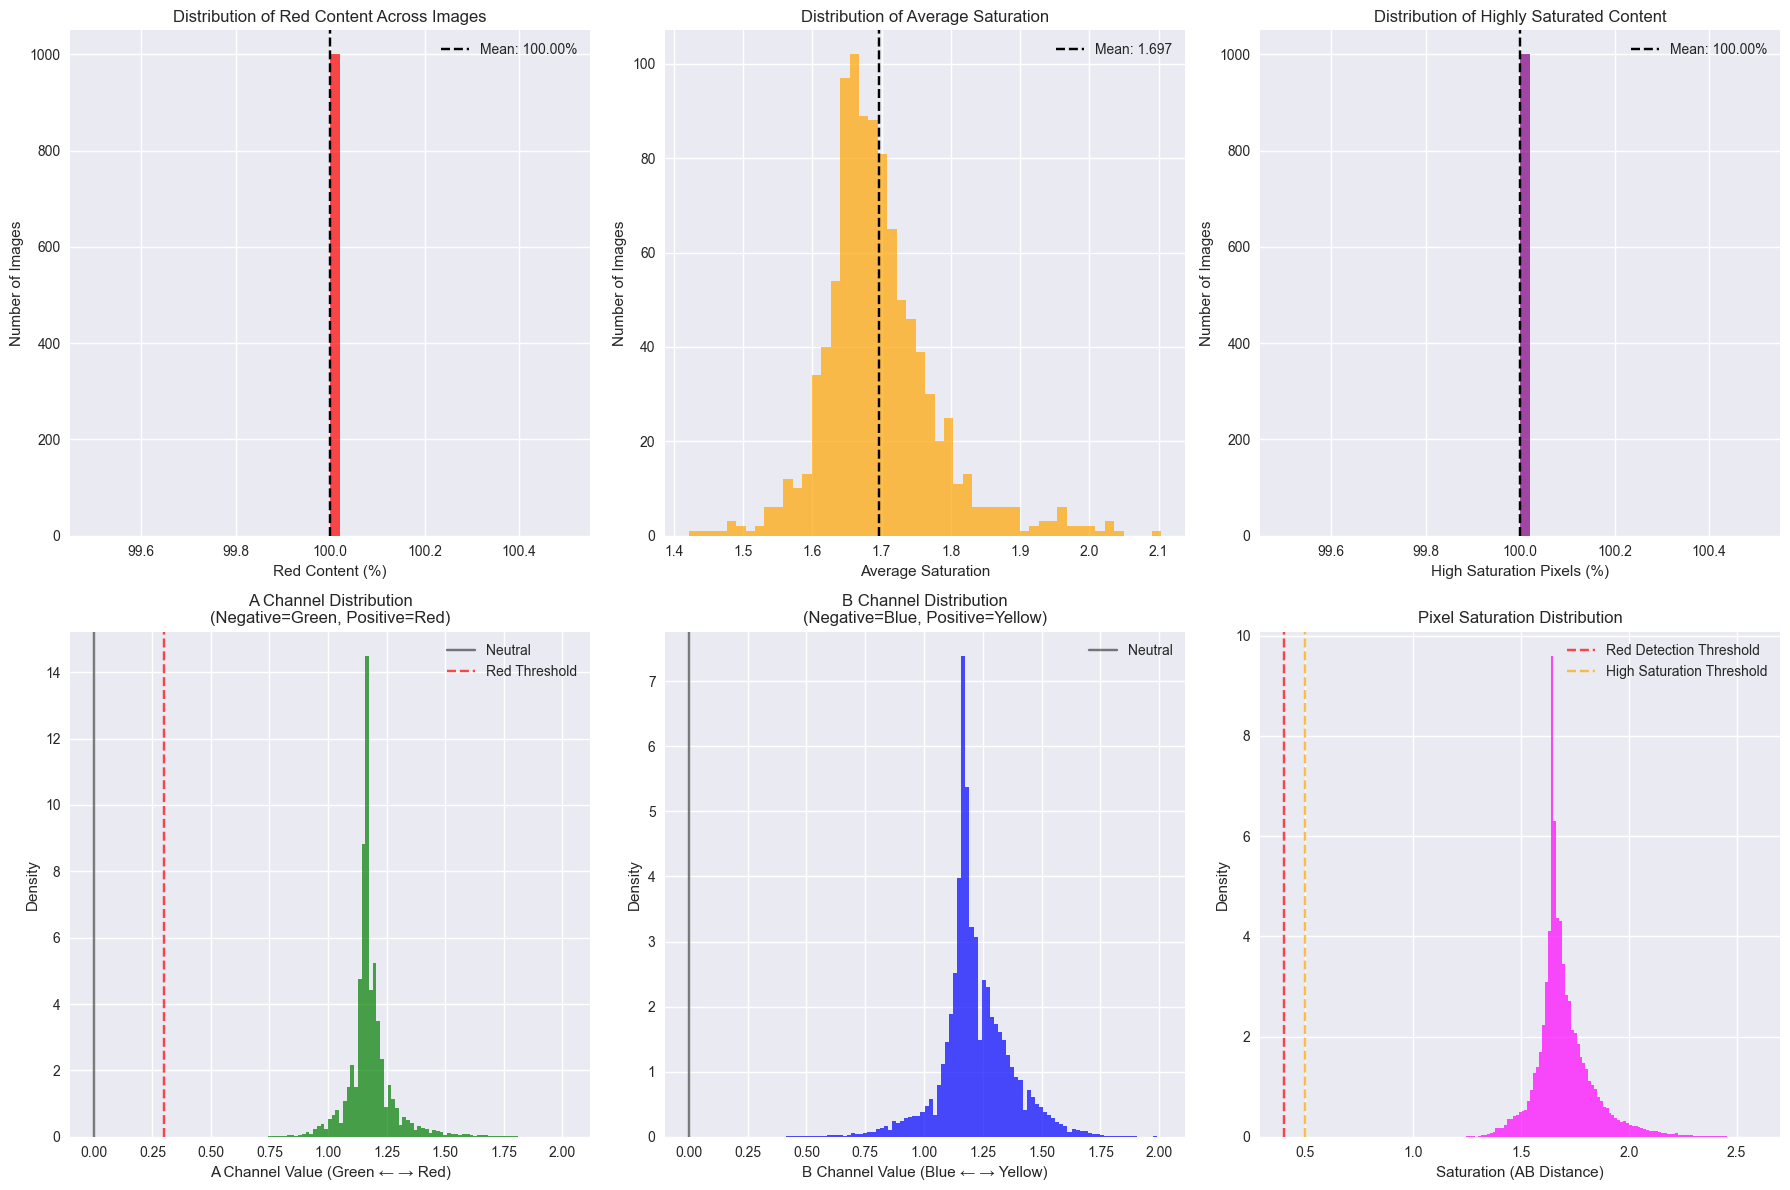


=== PIXEL-LEVEL STATISTICS ===
A channel mean: 1.177 (should be ~0 for balanced dataset)
B channel mean: 1.217 (should be ~0 for balanced dataset)
Percentage of pixels with A > 0.3 (reddish): 100.00%
Percentage of pixels with saturation > 0.4: 100.00%
Percentage of pixels with saturation > 0.5: 100.00%


In [6]:
if train_stats and all_a_values:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Red content distribution
    axes[0, 0].hist(red_percentages, bins=50, alpha=0.7, color='red')
    axes[0, 0].set_xlabel('Red Content (%)')
    axes[0, 0].set_ylabel('Number of Images')
    axes[0, 0].set_title('Distribution of Red Content Across Images')
    axes[0, 0].axvline(np.mean(red_percentages), color='black', linestyle='--', label=f'Mean: {np.mean(red_percentages):.2f}%')
    axes[0, 0].legend()
    
    # Saturation distribution
    axes[0, 1].hist(avg_saturations, bins=50, alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Average Saturation')
    axes[0, 1].set_ylabel('Number of Images')
    axes[0, 1].set_title('Distribution of Average Saturation')
    axes[0, 1].axvline(np.mean(avg_saturations), color='black', linestyle='--', label=f'Mean: {np.mean(avg_saturations):.3f}')
    axes[0, 1].legend()
    
    # High saturation percentage
    axes[0, 2].hist(high_sat_percentages, bins=50, alpha=0.7, color='purple')
    axes[0, 2].set_xlabel('High Saturation Pixels (%)')
    axes[0, 2].set_ylabel('Number of Images')
    axes[0, 2].set_title('Distribution of Highly Saturated Content')
    axes[0, 2].axvline(np.mean(high_sat_percentages), color='black', linestyle='--', label=f'Mean: {np.mean(high_sat_percentages):.2f}%')
    axes[0, 2].legend()
    
    # A channel distribution (Green-Red axis)
    axes[1, 0].hist(all_a_values, bins=100, alpha=0.7, color='green', density=True)
    axes[1, 0].set_xlabel('A Channel Value (Green ← → Red)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('A Channel Distribution\n(Negative=Green, Positive=Red)')
    axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5, label='Neutral')
    axes[1, 0].axvline(0.3, color='red', linestyle='--', alpha=0.7, label='Red Threshold')
    axes[1, 0].legend()
    
    # B channel distribution (Blue-Yellow axis)
    axes[1, 1].hist(all_b_values, bins=100, alpha=0.7, color='blue', density=True)
    axes[1, 1].set_xlabel('B Channel Value (Blue ← → Yellow)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('B Channel Distribution\n(Negative=Blue, Positive=Yellow)')
    axes[1, 1].axvline(0, color='black', linestyle='-', alpha=0.5, label='Neutral')
    axes[1, 1].legend()
    
    # Saturation distribution
    axes[1, 2].hist(all_saturations, bins=100, alpha=0.7, color='magenta', density=True)
    axes[1, 2].set_xlabel('Saturation (AB Distance)')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].set_title('Pixel Saturation Distribution')
    axes[1, 2].axvline(0.4, color='red', linestyle='--', alpha=0.7, label='Red Detection Threshold')
    axes[1, 2].axvline(0.5, color='orange', linestyle='--', alpha=0.7, label='High Saturation Threshold')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics
    print("\n=== PIXEL-LEVEL STATISTICS ===")
    print(f"A channel mean: {np.mean(all_a_values):.3f} (should be ~0 for balanced dataset)")
    print(f"B channel mean: {np.mean(all_b_values):.3f} (should be ~0 for balanced dataset)")
    print(f"Percentage of pixels with A > 0.3 (reddish): {np.sum(np.array(all_a_values) > 0.3) / len(all_a_values) * 100:.2f}%")
    print(f"Percentage of pixels with saturation > 0.4: {np.sum(np.array(all_saturations) > 0.4) / len(all_saturations) * 100:.2f}%")
    print(f"Percentage of pixels with saturation > 0.5: {np.sum(np.array(all_saturations) > 0.5) / len(all_saturations) * 100:.2f}%")
else:
    print("No data available for visualization")

## AB Color Space Visualization

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


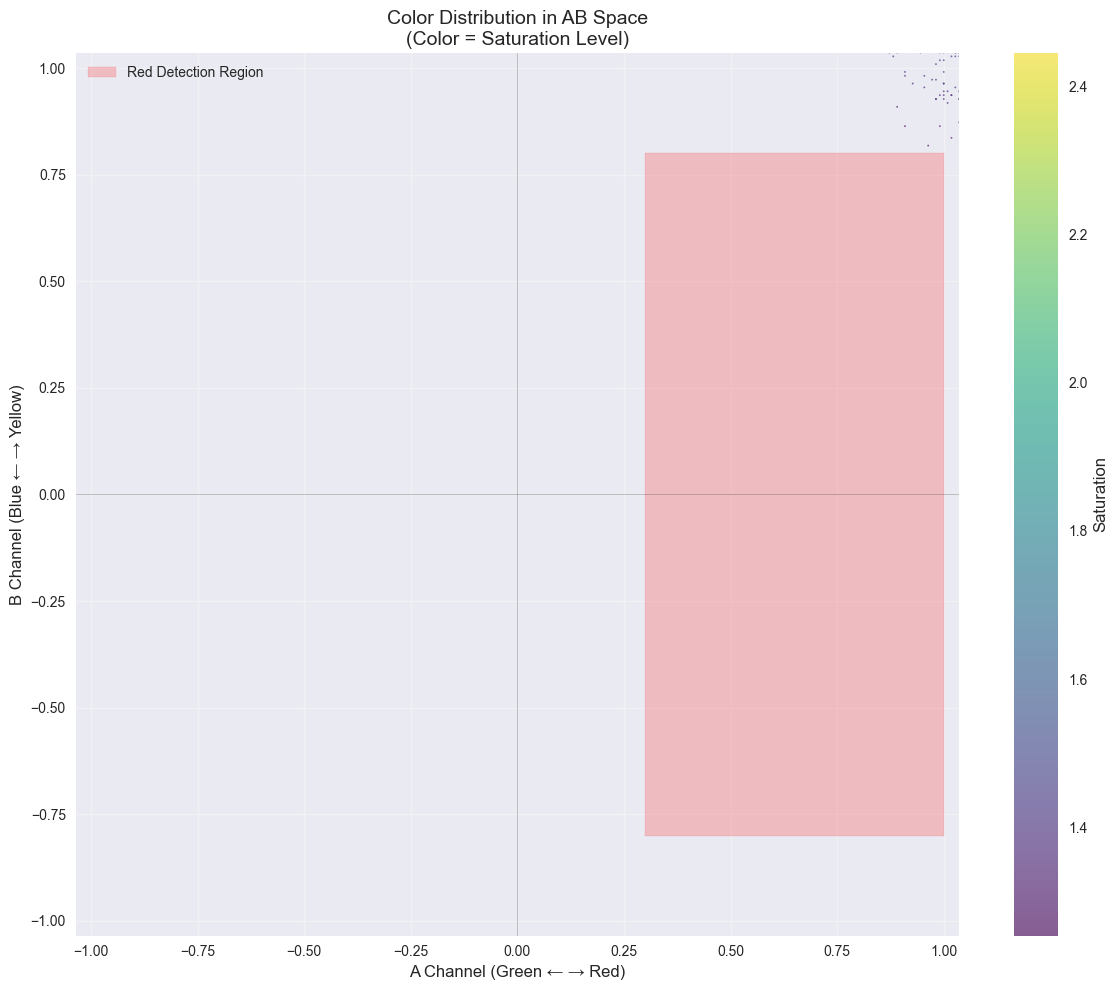


=== AB SPACE QUADRANT ANALYSIS ===
Red-Yellow quadrant (A>0, B>0): 100.0%
Green-Yellow quadrant (A<0, B>0): 0.0%
Green-Blue quadrant (A<0, B<0): 0.0%
Red-Blue quadrant (A>0, B<0): 0.0%

Total in 'reddish' quadrants: 100.0%


In [7]:
if all_a_values and all_b_values:
    # Create AB space scatter plot
    plt.figure(figsize=(12, 10))
    
    # Subsample for visualization (too many points can be slow)
    sample_size = min(10000, len(all_a_values))
    sample_idx = np.random.choice(len(all_a_values), sample_size, replace=False)
    
    a_sample = np.array(all_a_values)[sample_idx]
    b_sample = np.array(all_b_values)[sample_idx]
    sat_sample = np.array(all_saturations)[sample_idx]
    
    # Create scatter plot colored by saturation
    scatter = plt.scatter(a_sample, b_sample, c=sat_sample, alpha=0.6, s=1, cmap='viridis')
    
    plt.xlabel('A Channel (Green ← → Red)', fontsize=12)
    plt.ylabel('B Channel (Blue ← → Yellow)', fontsize=12)
    plt.title('Color Distribution in AB Space\n(Color = Saturation Level)', fontsize=14)
    
    # Add reference lines
    plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    plt.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    
    # Mark red region
    red_a = np.linspace(0.3, 1.0, 100)
    red_b_upper = np.full_like(red_a, 0.8)
    red_b_lower = np.full_like(red_a, -0.8)
    plt.fill_between(red_a, red_b_lower, red_b_upper, alpha=0.2, color='red', label='Red Detection Region')
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Saturation', fontsize=12)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Print quadrant analysis
    print("\n=== AB SPACE QUADRANT ANALYSIS ===")
    q1 = np.sum((a_sample > 0) & (b_sample > 0)) / len(a_sample) * 100  # Red-Yellow
    q2 = np.sum((a_sample < 0) & (b_sample > 0)) / len(a_sample) * 100  # Green-Yellow
    q3 = np.sum((a_sample < 0) & (b_sample < 0)) / len(a_sample) * 100  # Green-Blue
    q4 = np.sum((a_sample > 0) & (b_sample < 0)) / len(a_sample) * 100  # Red-Blue
    
    print(f"Red-Yellow quadrant (A>0, B>0): {q1:.1f}%")
    print(f"Green-Yellow quadrant (A<0, B>0): {q2:.1f}%")
    print(f"Green-Blue quadrant (A<0, B<0): {q3:.1f}%")
    print(f"Red-Blue quadrant (A>0, B<0): {q4:.1f}%")
    
    red_quadrants = q1 + q4
    print(f"\nTotal in 'reddish' quadrants: {red_quadrants:.1f}%")
else:
    print("No AB data available for visualization")